In [1]:
import multiprocessing as mp
from util.backtest import *
from util.factor_util import *
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
from tqdm import tqdm
import warnings
from time import sleep
import statsmodels.api as sm
import os
import glob

plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] =False

In [2]:
INSAMPLE_END_DATE = datetime(2021,7,1)
VALID_END_DATE = datetime(2022,6,1)
SAMPLE_END_DATE = datetime(2022,8,31)

FREQ = 'D'


files = glob.glob('/home/frank/document/Python/Factors/data/1m_data/*.csv')
ls = []
for file in files:
    df = pd.read_csv(file)
    
    df['BuyerRatio'] = df['takerBuyQuoteVol']/df['quoteAssetVolume']
    df['BuyerPerTrade'] = df['takerBuyQuoteVol']/df['numberOfTrades']
    df['VolumePerTrade'] = df['quoteAssetVolume']/df['numberOfTrades']

    df = df.drop(['Volume','ignore','numberOfTrades','takerBuyBaseVol'],axis= 1)
    
    ls.append(df)
df = pd.concat(ls)
print('Dataframe prepared completed')

Dataframe prepared completed


In [3]:
categories = {}
with open('/home/frank/document/Python/Factors/data/Crytpo_categories.json','r') as f:
    categories = json.loads(f.read())    
categories['all'] = df.symbol.unique()
for category in categories.keys():
    print(category,len(categories[category]))


token 113
coin 65
Ethereum 101
Solana-ecosystem 15
bnb-chain 43
Polkadot 17
defi 68
innovation 24
gaming 18
nft 33
infrastructure 16
layer1_layer2 35
pos 47
pow 20
all 183


In [4]:
col_list = ['Open','High','Low','Close','quoteAssetVolume','takerBuyQuoteVol','BuyerRatio']
df_data = {}
for col in col_list:
    df_data[col] = df.pivot(values = col,index = 'openTime',columns = 'symbol').astype(float)
    df_data[col].index = pd.to_datetime(df_data[col].index,unit = 'ms') #+ timedelta(hours=8)

print("Pivot table completed")

In [5]:
market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(7*24).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter & (volume_filter>0.5)
GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()

ret = df_data['Close'].sort_index().resample(FREQ).last().bfill().pct_change().fillna(0)


In [21]:
metrics = pd.read_csv('/home/frank/document/Python/Factors/output/backtest_result/D/level1_metrics.csv',index_col = 0)
# metrics = pd.read_csv('/home/frank/document/Python/Factors/output/backtest_result/D/backtest_metrics_20230221.csv',index_col = 0)
print(metrics.shape)
metrics = metrics.sort_index().drop_duplicates('Sharpe').sort_values('Fitnessvalue',ascending = False)
metrics = metrics[metrics['Insample Sharpe']*0.5< metrics['Outsample Sharpe']]
metrics = metrics[metrics['Sharpe'] != metrics['Fitnessvalue']]
metrics = metrics[metrics['Sharpe'] >=1]
# metrics = metrics[(metrics['Long Fitness'] >= 0) & (metrics['Short Fitness'] >= 0)]

print(metrics.shape)
# print(metrics.sort_values('Fitnessvalue',ascending = False).index[:20])
metrics.sort_values('Fitnessvalue',ascending = False).head()#.shape


(35235, 16)
(680, 16)


,Sharpe,Fitnessvalue,Insample Sharpe,Outsample Sharpe,Long Fitness,Short Fitness,Long Insample Fitness,Short Insample Fitness,Long Outsample Fitness,Short Outsample Fitness,Insample Long Alpha,Insample Long Beta,Insample Long R^2,Insample Short Alpha,Insample Short Beta,Insample Short R^2
Strategy,,,,,,,,,,,,,,,,
Open/Close.Kurt_Reverse,3.109859,1.590269,1.392073,2.035232,0.345977,0.117711,0.806315,-0.713941,-0.089872,0.448333,NaN,NaN,NaN,NaN,NaN,NaN
Close/Low.SignedPower.Kurt.Abs_Reverse,2.845424,1.422712,1.611416,2.029279,0.319388,0.069677,0.798482,-0.862122,0.021826,0.349126,NaN,NaN,NaN,NaN,NaN,NaN
Close/Low.Kurt.Pct_Change_Reverse,2.875106,1.306866,1.285509,2.633847,0.347139,0.034376,0.603316,-0.885736,0.178837,0.249202,NaN,NaN,NaN,NaN,NaN,NaN
Open/Close.SignedPower.Kurt.Pct_Change_Reverse,3.156435,1.219532,2.184844,2.112798,0.374379,0.075095,0.970005,-0.466000,0.074611,0.217183,NaN,NaN,NaN,NaN,NaN,NaN
Close/Low.Skew.Abs.Pct_Change_Reverse,2.744044,1.184928,0.694295,3.153661,0.415206,0.048280,0.676741,-0.855135,0.288052,0.363390,NaN,NaN,NaN,NaN,NaN,NaN


##  Selected

High.Rank.Skew_Reverse


/home/frank/.local/lib/python3.10/site-packages/pandas/core/window/rolling.py:579: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
/home/frank/.local/lib/python3.10/site-packages/pandas/core/window/rolling.py:579: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
/home/frank/.local/lib/python3.10/site-packages/pandas/core/window/rolling.py:579: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
/home/frank/.local/lib/python3.10/site-packages/pandas/core/window/rolling.py:579: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)


<AxesSubplot:title={'center':'High.Rank.Skew_Reverse'}, xlabel='openTime'>

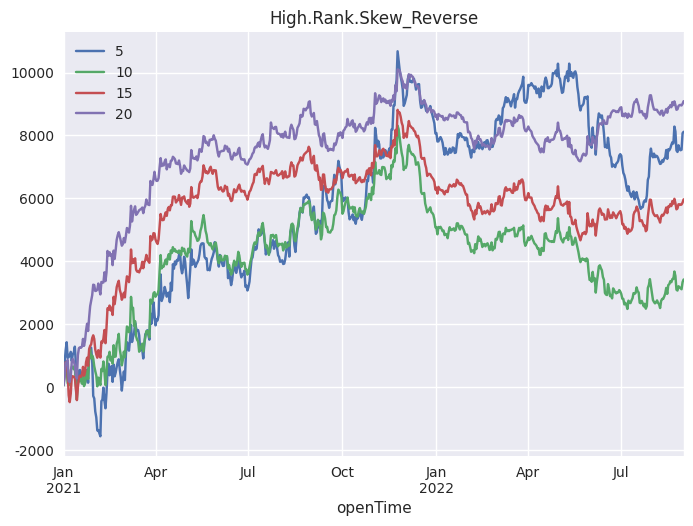

In [17]:
name = 'BuyerRatio*Low/High.Min.Skew.Quantile25_Reverse'#metrics.index[400]
name = 'High.Rank.Skew_Reverse'
stress_score = {}
print(name)
for selected in range(5,25,5):
    # selected = 5
    data = name.replace('_Reverse','').split('.')
    formula = '.'.join(data[1:])
    data = data[0]
    # print(name)
    factor1 = calc_factors(calc_input_data(df_data,data),formula)


    factor = factor1.sort_index().resample(FREQ).last()
    cond = GLOBAL_FILTER 

    if '_Reverse' in name:
        factor *= -1


    rk = factor[cond].rank(axis = 1,pct = True,ascending = True,method = 'dense')
    rk = (rk*100).apply(lambda x: np.floor(x))
    # rk[rk==10] -= 1

    long_signal = rk.copy()
    long_signal[:] = 0
    short_signal = long_signal.copy()

    long_signal[rk>=100-selected] = 1 
    short_signal[rk<=selected] = -1 

    # if '_Reverse' in name:
    #     long_signal *= -1
    #     short_signal *= -1

    long_result = fast_backtest(ret,long_signal)#.sum(axis = 1)
    short_result = fast_backtest(ret,short_signal)#.sum(axis = 1)

    result = ((long_result + short_result)/2).sum(axis = 1)
    long_result = long_result.sum(axis = 1)
    short_result = short_result.sum(axis = 1)

    # show_return(result.loc[datetime(2021,1,1):],figsize= (12,4))
    score = show_performance_metrics(result.loc[datetime(2021,1,1):],show = False)['FitnessValue']
    # stress_score.append(score)
    stress_score[selected] = result.loc[datetime(2021,1,1):SAMPLE_END_DATE]
    # break
stress_score
pd.DataFrame(stress_score).cumsum().plot(title=name)

## Subsets

In [293]:
subsets = ['all','token','coin','Ethereum','bnb-chain','defi','nft','gaming']

In [310]:
name = metrics.index[10]

stress_score = {}
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]
# print(name)
factor1 = calc_factors(calc_input_data(df_data,data),formula)


factor = factor1.sort_index().resample(FREQ).last()
cond = GLOBAL_FILTER 

if '_Reverse' in name:
    factor *= -1

    
for subset in subsets[:]:
    subset_name = subset
    subset = categories[subset_name]
    if subset_name != 'all':
        subset = np.unique([sym + 'usdt' for sym in subset])

    market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
    volume = df_data['quoteAssetVolume'].sort_index().rolling(7*24).sum().fillna(0)
    volume_filter = volume[(market_filter)][subset].rank(axis = 1,pct = True,ascending = True,method = 'dense')
    filter = market_filter[subset] & (volume_filter>0.5)
    filter = filter.resample('D').last()
    cond = filter.copy()




    factor_subset = factor[subset]
    ret_subset = ret[subset]

    selected = 10
    select = cond.sum(axis = 1) * selected * 0.01
    select = select.apply(lambda x:max(np.floor(x),2))
    


    rk = factor_subset[cond].rank(axis = 1,ascending = True,method = 'dense')


    long_signal = rk.copy()
    long_signal[:] = 0
    short_signal = long_signal.copy()

    long_signal[rk.gt(cond.sum(axis = 1) - select,axis = 0)] = 1 
    short_signal[rk.le(select,axis = 0)] = -1 

    long_result = fast_backtest(ret,long_signal)#.sum(axis = 1)
    short_result = fast_backtest(ret,short_signal)#.sum(axis = 1)

    result = ((long_result + short_result)/2).sum(axis = 1)
    long_result = long_result.sum(axis = 1)
    short_result = short_result.sum(axis = 1)

    score = show_performance_metrics(result.loc[datetime(2021,1,1):],show = False)['FitnessValue']
    stress_score[subset_name] = result.loc[datetime(2021,1,1):]
    # break

In [317]:
list(itertools.product([24*7],repeat = 3))[0]

[(168, 168, 168)]

<AxesSubplot:xlabel='openTime'>

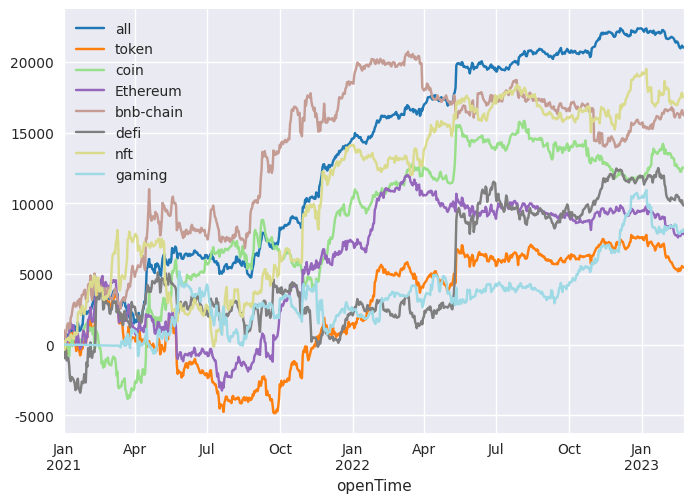

In [311]:
cmap = cm.get_cmap('tab20',pd.DataFrame(stress_score).shape[1]) # Colour map (there are many others)

pd.DataFrame(stress_score).loc[datetime(2021,1,1):].cumsum().plot(colormap=cmap)


In [ ]:
list(itertools.product(list(range(24,30*24 + 8,8)),repeat = params))

## Hypertune First

In [100]:
name = metrics.index[10]
print(name)
stress_score = {}
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]

operators = formula.split('.')
vol_len = [24,24*3,24*7,24*14,24*30]
params = sum([1 for operator in operators if operator not in FORMULAS_PARAM_FREE])
params = list(itertools.product(list(range(24,30*24 + 8,8)),repeat = params))
params = list(itertools.product(vol_len,params))

np.random.shuffle(params)

print(len(params))

Close/Low.Kurt.Pct_Change_Reverse
38720


In [77]:
# list()
list(itertools.product(list(range(24,24*8,24)),params))
params[0]

(72, (160, 648))

In [103]:
navs = {}
hypertune_metrics = {}

for param in tqdm(params[:10**3 * 3]):
    factor1 = calc_factors(calc_input_data(df_data,data),formula,param[1])
    factor = factor1.sort_index().resample(FREQ).last()
    cond = GLOBAL_FILTER 

    if '_Reverse' in name:
        factor *= -1


    market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
    volume = df_data['quoteAssetVolume'].sort_index().rolling(param[0]).sum().fillna(0)
    volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
    GLOBAL_FILTER = market_filter & (volume_filter>0.5)
    GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()


    selected = 10
    data = name.replace('_Reverse','').split('.')
    formula = '.'.join(data[1:])
    data = data[0]
    # print(name)

    select = cond.sum(axis = 1) * selected * 0.01
    select = select.apply(lambda x:max(np.floor(x),3))



    rk = factor[cond].rank(axis = 1,ascending = True,method = 'dense')

    long_signal = rk.copy()
    long_signal[:] = 0
    short_signal = long_signal.copy()

    long_signal[rk.gt(cond.sum(axis = 1) - select,axis = 0)] = 1 
    short_signal[rk.le(select,axis = 0)] = -1 

    long_result = fast_backtest(ret,long_signal)#.sum(axis = 1)
    short_result = fast_backtest(ret,short_signal)#.sum(axis = 1)

    result = ((long_result + short_result)/2).sum(axis = 1)
    long_result = long_result.sum(axis = 1)
    short_result = short_result.sum(axis = 1)

    score = show_performance_metrics(result.loc[datetime(2021,1,1):SAMPLE_END_DATE],show = False)
    IS_score = show_performance_metrics(result.loc[datetime(2021,1,1):INSAMPLE_END_DATE],show = False)#['FitnessValue']
    OS_score = show_performance_metrics(result.loc[datetime(2021,1,1):SAMPLE_END_DATE],show = False)
    # param = {'len1':param[0],'len2':param[1]}
    hypertune_metrics[tuple([param[0]] + list(param[1]))] = IS_score
    
    # break


100%|██████████| 3000/3000 [24:58<00:00,  2.00it/s]


In [95]:
# param[param[0]] + list(param[1])
tuple([param[0]] + list(param[1]))

(168, 608, 632, 400)

In [133]:
','.join([f'{value:.6f}' for value in list(IS_score.values())])
','.join([value for value in list(IS_score.keys())])

'Net_profit(%),MDD(%),Profit_mdd,Sharpe,ATH_Score,Monthly_Return_Score,Cummax_Score,FitnessValue'

In [104]:
tmp = pd.DataFrame(hypertune_metrics).T
tmp.index.names = ['vol_len'] + [f'len{i+1}'for i in range(len(operators))]
tmp
# [f'len{i+1}'for i in range(len(operators))]

Net_profit(%)      MDD(%)  Profit_mdd    Sharpe  ATH_Score  \
vol_len len1 len2                                                               
24      680  616      -14.663719   58.408687   -0.251054 -0.360154   0.038462   
        608  352       -6.593509   38.889454   -0.169545 -0.167432   0.043956   
720     472  480      -95.571095  107.576453   -0.888402 -2.107358   0.032967   
168     576  192       -3.239597   29.793938   -0.108733 -0.096634   0.120879   
        224  336      -42.147825   69.676285   -0.604909 -0.979457   0.027473   
...                          ...         ...         ...       ...        ...   
720     136  232      -11.032306   30.670819   -0.359700 -0.331609   0.049451   
168     640  344       20.460077   16.556368    1.235783  0.647656   0.109890   
24      352  168      -63.945301   71.977497   -0.888407 -1.746737   0.027473   
        88   616      -57.839486   79.264747   -0.729700 -1.585936   0.060440   
720     320  640      -69.378044   98.019217   -0.707800 -1.674666   0.060440   

                   Monthly_Return_Score  Cummax_Score  FitnessValue  
vol_len len1 len2                                                    
24      680  616               0.571429      0.111111     -0.400171  
        608  352               0.428571      0.111111     -0.186035  
720     472  480               0.000000      0.074074     -2.263459  
168     576  192               0.571429      0.296296     -0.125266  
        224  336               0.142857      0.074074     -1.052010  
...                                 ...           ...           ...  
720     136  232               0.142857      0.148148     -0.380736  
168     640  344               0.571429      0.222222      0.143923  
24      352  168               0.142857      0.037037     -1.811430  
        88   616               0.142857      0.148148     -1.820890  
720     320  640               0.285714      0.074074     -1.798716  

[3000 rows x 8 columns]

In [112]:
print(name)
tmp1 = tmp.reset_index()
tmp1[tmp1.len1>tmp1.len2].sort_values('len1')

Close/Low.Kurt.Pct_Change_Reverse


,vol_len,len1,len2,Net_profit(%),MDD(%),Profit_mdd,Sharpe,ATH_Score,Monthly_Return_Score,Cummax_Score,FitnessValue
879,24,40,24,-11.728997,20.296389,-0.577886,-0.367934,0.021978,0.285714,0.148148,-0.422443
1122,336,40,24,-13.301499,29.782640,-0.446619,-0.432768,0.065934,0.142857,0.111111,-0.480853
2258,168,40,24,21.311229,17.288374,1.232691,0.636290,0.087912,0.285714,0.185185,0.117831
2037,720,40,24,-11.728997,20.296389,-0.577886,-0.367934,0.021978,0.285714,0.148148,-0.422443
865,336,48,24,-63.209494,69.478899,-0.909765,-1.957140,0.010989,0.285714,0.037037,-2.029627
...,...,...,...,...,...,...,...,...,...,...,...
883,72,720,264,107.647684,14.325661,7.514326,2.877420,0.263736,1.000000,0.518519,1.491996
1254,720,720,296,36.253152,32.145496,1.127783,0.961482,0.087912,0.714286,0.185185,0.178052
1675,336,720,280,43.325951,20.540290,2.109316,1.198182,0.142857,1.000000,0.333333,0.399394
88,168,720,408,43.325951,20.540290,2.109316,1.198182,0.142857,1.000000,0.333333,0.399394


In [114]:
720+408

1128

In [113]:
factor.shape

(1151, 182)

## Hypertune Second

In [323]:
strategies = pd.read_csv('/home/frank/document/Python/Factors/output/backtest_result/D/level1_metrics.csv').Strategy.sort_values().to_list()


In [304]:
import hiplot,glob
files = glob.glob('./output/hypertune/level1/*.csv')
_dir = files[10]

df = pd.read_csv(_dir)


plt = hiplot.Experiment.from_dataframe(df)
plt.display()


<IPython.core.display.Javascript object>

In [392]:
tmp = df[(df['FitnessValue']>0) & (df['FitnessValue']<df.FitnessValue.drop_duplicates().quantile(0.99))].sort_values('FitnessValue')#.drop_duplicates('Sharpe')
tmp = tmp[(tmp['FitnessValue']>=tmp['FitnessValue'].drop_duplicates().quantile(0.75))]
tmp#.drop_duplicates('Sharpe')

,vol_len,len1,len2,len3,Net_profit(%),MDD(%),Profit_mdd,Sharpe,ATH_Score,Monthly_Return_Score,Cummax_Score,FitnessValue
797,168,200,560,40,32.886962,39.728931,0.827784,0.767862,0.098901,0.714286,0.222222,0.170636
1483,168,200,80,624,32.886962,39.728931,0.827784,0.767862,0.098901,0.714286,0.222222,0.170636
889,168,200,608,312,32.886962,39.728931,0.827784,0.767862,0.098901,0.714286,0.222222,0.170636
1233,168,200,248,336,32.886962,39.728931,0.827784,0.767862,0.098901,0.714286,0.222222,0.170636
1246,168,200,80,552,32.886962,39.728931,0.827784,0.767862,0.098901,0.714286,0.222222,0.170636
...,...,...,...,...,...,...,...,...,...,...,...,...
4044,336,168,360,536,58.203029,23.026441,2.527661,1.551147,0.159341,0.714286,0.296296,0.459599
2054,336,168,264,520,58.203029,23.026441,2.527661,1.551147,0.159341,0.714286,0.296296,0.459599
466,336,168,136,64,58.203029,23.026441,2.527661,1.551147,0.159341,0.714286,0.296296,0.459599
3371,336,168,472,392,58.203029,23.026441,2.527661,1.551147,0.159341,0.714286,0.296296,0.459599


In [393]:
name = strategies[int(_dir.split('_')[-1][:-4])]

data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]
operators = formula.split('.')


In [394]:
tmp1.len1.quantile(0.25)
vol_len = tmp['vol_len'].unique()
param_count = sum([1 for operator in operators if operator not in FORMULAS_PARAM_FREE])
params = []
for i in range(param_count):
    param = tmp[tmp.columns[i+1]]
    start = int(np.floor(tmp[tmp.columns[1]].quantile(0.25) / 8) * 8)
    end = int(np.floor(tmp[tmp.columns[1]].quantile(0.95) / 8) * 8)
    params.append(list(range(start,end + 8,8)))
    # break
# params[1]
tmp[tmp.columns[1]].quantile(0.95)

200.0

In [399]:
len(params)
params[i]
# param_count
params[0]

[[80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200],
 [80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200],
 [80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200]]

In [401]:
result = list(itertools.product(*params[:]))
result = list(itertools.product(vol_len,result))

len(result)
result[:5]

[(168, (80, 80, 80)),
 (168, (80, 80, 88)),
 (168, (80, 80, 96)),
 (168, (80, 80, 104)),
 (168, (80, 80, 112))]

In [402]:
total = int(tmp.shape[0]/2)
partial = int(total/5)
i = 4
selected = tmp.iloc[tmp.shape[0] - partial * (i+1) : tmp.shape[0] - partial * (i)]
selected.iloc[np.random.randint(0,selected.shape[0],size = 2)]

,vol_len,len1,len2,len3,Net_profit(%),MDD(%),Profit_mdd,Sharpe,ATH_Score,Monthly_Return_Score,Cummax_Score,FitnessValue
3306,24,48,296,352,24.230593,38.69507,0.626193,0.727216,0.065934,0.714286,0.333333,0.242405
633,24,48,416,664,24.230593,38.69507,0.626193,0.727216,0.065934,0.714286,0.333333,0.242405


In [408]:
ls = []
for i in range(5):
    selected = tmp.iloc[tmp.shape[0] - partial * (i+1) : tmp.shape[0] - partial * (i)]
    selected = selected.iloc[np.random.randint(0,selected.shape[0],size = 2)]
    ls.append(selected)

selected#.shape
selected = pd.concat(ls,axis = 0)
selected.sort_values('')

,vol_len,len1,len2,len3,Net_profit(%),MDD(%),Profit_mdd,Sharpe,ATH_Score,Monthly_Return_Score,Cummax_Score,FitnessValue
3586,336,168,664,120,58.203029,23.026441,2.527661,1.551147,0.159341,0.714286,0.296296,0.459599
667,24,184,408,408,52.508273,46.682709,1.124791,1.102178,0.170330,0.714286,0.370370,0.408214
2876,24,24,152,248,28.992271,17.814119,1.627488,0.944096,0.148352,0.714286,0.407407,0.384632
1732,24,80,312,536,35.768935,20.686647,1.729083,1.075787,0.115385,0.571429,0.296296,0.318752
2870,336,200,384,88,43.028548,45.112372,0.953808,1.068476,0.109890,0.571429,0.296296,0.316586
2269,24,160,456,640,47.533820,40.940657,1.161042,1.088719,0.126374,0.571429,0.259259,0.282261
116,72,168,88,680,41.530791,38.723257,1.072503,1.008840,0.120879,0.571429,0.259259,0.261551
3961,336,160,376,552,41.379502,36.281195,1.140522,1.111050,0.137363,0.571429,0.222222,0.246900
3306,24,48,296,352,24.230593,38.695070,0.626193,0.727216,0.065934,0.714286,0.333333,0.242405
3656,24,152,376,704,47.779609,53.919796,0.886124,1.079664,0.137363,0.714286,0.222222,0.239925


In [407]:
test_dict ={}
test_dict[tuple(selected[selected.columns[:param_count+1]].values[0])] = [100]
test_dict

{(24, 184, 568, 344): [100]}

In [380]:
len(glob.glob('./output/hypertune/level1/*.csv'))

302

In [383]:
selected

,vol_len,len1,len2,len3,Net_profit(%),MDD(%),Profit_mdd,Sharpe,ATH_Score,Monthly_Return_Score,Cummax_Score,FitnessValue
3165,24,152,448,80,47.779609,53.919796,0.886124,1.079664,0.137363,0.714286,0.222222,0.239925
1955,24,168,288,88,48.643779,34.256448,1.419989,1.099166,0.131868,0.714286,0.222222,0.244259


{'Net_profit(%)': 126.17510488313626,
 'MDD(%)': 21.468728246600513,
 'Profit_mdd': 5.877157856479719,
 'Sharpe': 2.180827857889855,
 'ATH_Score': 0.11479591836734694,
 'Monthly_Return_Score': 0.7307692307692307,
 'Cummax_Score': 0.3008849557522124,
 'FitnessValue': 0.6561782935243812}

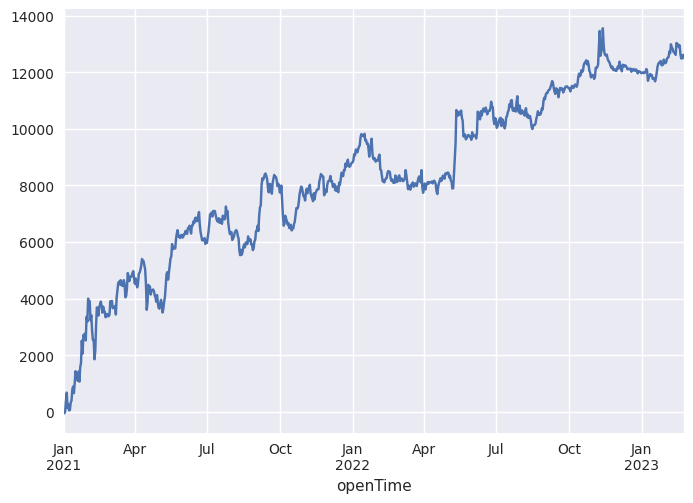

In [236]:
name = strategies[int(_dir.split('_')[-1][:-4])]

data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]
operators = formula.split('.')

param = (336,(656,))
factor1 = calc_factors(calc_input_data(df_data,data),formula,param[1])
factor = factor1.sort_index().resample(FREQ).last()
cond = GLOBAL_FILTER 


market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(param[0]).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter & (volume_filter>0.5)
GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()


selected = 10
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]
# print(name)

select = cond.sum(axis = 1) * selected * 0.01
select = select.apply(lambda x:max(np.floor(x),3))



if '_Reverse' in name:
    factor *= -1


rk = factor[cond].rank(axis = 1,ascending = True,method = 'dense')

long_signal = rk.copy()
long_signal[:] = 0
short_signal = long_signal.copy()

long_signal[rk.gt(cond.sum(axis = 1) - select,axis = 0)] = 1 
short_signal[rk.le(select,axis = 0)] = -1 

long_result = fast_backtest(ret,long_signal)#.sum(axis = 1)
short_result = fast_backtest(ret,short_signal)#.sum(axis = 1)

result = ((long_result + short_result)/2).sum(axis = 1)
long_result = long_result.sum(axis = 1)
short_result = short_result.sum(axis = 1)


score = show_performance_metrics(result.loc[datetime(2021,1,1):],show = False)
IS_score = show_performance_metrics(result.loc[datetime(2021,1,1):INSAMPLE_END_DATE],show = False)#['FitnessValue']
OS_score = show_performance_metrics(result.loc[datetime(2021,1,1):SAMPLE_END_DATE],show = False)
# param = {'len1':param[0],'len2':param[1]}
hypertune_metrics[tuple([param[0]] + list(param[1]))] = IS_score
result.loc[datetime(2021,1,1):].cumsum().plot()
score

{'Net_profit(%)': 1.3179803163497756,
 'MDD(%)': 39.99284924656156,
 'Profit_mdd': 0.032955399307117154,
 'Sharpe': 0.0359607114702091,
 'ATH_Score': 0.054945054945054944,
 'Monthly_Return_Score': 0.42857142857142855,
 'Cummax_Score': 0.1111111111111111,
 'FitnessValue': 0.0039956346078010106}

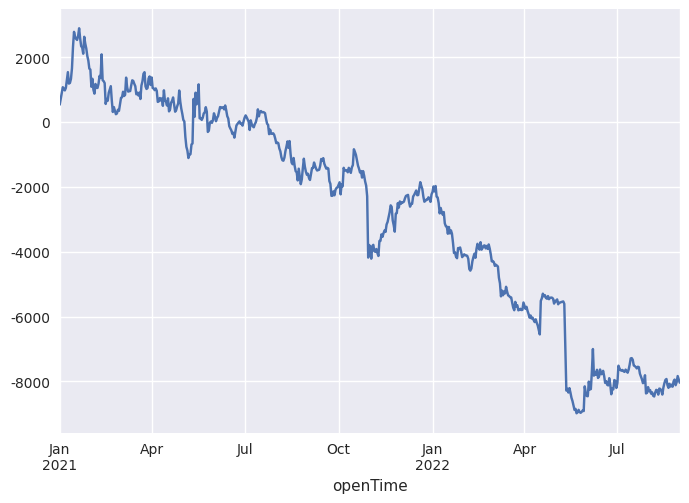

In [145]:
result.loc[datetime(2021,1,1):SAMPLE_END_DATE].cumsum().plot()
IS_score